# Цель проекта: Выявить закономерности, определяющие успешность компьютерной игры. 

## Задачи проекта.
1. Подсчитать суммарные продажи во всех представленных регионах.
2. Выбрать несколько потенциально прибыльных платформ.
3. Определить, влияют ли на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
4. Определить самые прибыльные жанры.
5. Составить портрет пользователя каждого региона.

Решение этих задач позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Описание данных

**Name** — название игры.

**Platform** — платформа.

**Year_of_Release** — год выпуска.

**Genre** — жанр игры.

**NA_sales** — продажи в Северной Америке (миллионы проданных копий).

**EU_sales** — продажи в Европе (миллионы проданных копий).

**JP_sales** — продажи в Японии (миллионы проданных копий).

**Other_sales** — продажи в других странах (миллионы проданных копий).

**Critic_Score** — оценка критиков (максимум 100).

**User_Score** — оценка пользователей (максимум 10).

**Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

# Шаг 1

In [2]:
# загружаем библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm
from scipy.stats import binom
from matplotlib import pyplot as plt

In [3]:
# загружаем данные
try:
    df = pd.read_csv('noname.csv')
except:
    df = pd.read_csv('https://code...noname.csv')

## Шаг 2. Подготовка данных

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Проверим какие столбцы есть в таблице

In [5]:
[col for col in df.columns]

['Name',
 'Platform',
 'Year_of_Release',
 'Genre',
 'NA_sales',
 'EU_sales',
 'JP_sales',
 'Other_sales',
 'Critic_Score',
 'User_Score',
 'Rating']

Все столбцы совпадают с описанием. Изменим все названия на нижний регистр.

In [6]:
df.rename(columns=str.lower, inplace=True)

Проверим данные на пропуски

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Мы видим пропуски в столбце Наименование, Жанр и Год выпуска. Их немного,поэтому удалим эти строки, т.к. это основная информация и без названия, жанра и года выпуска анализировать данные не имеет смысла.
Кроме того, столбец с годом выпуска игры предствален в виде дробного числа. Необходимо изменить тип данных на datatime.


In [8]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [9]:
df = df.dropna(subset=['name','genre','year_of_release'])

In [10]:
df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y')

Определим временной период представленных данных.

In [11]:
df['year'] = df['year_of_release'].dt.year

In [12]:
df['year'].min()

1980

In [13]:
df['year'].max()

2016

Время представления игр охватывает период с 1980 по 2016 годы.

Проверим ДФ на наличие дубликатов

In [14]:
df.duplicated().sum()

0

Дубликатов явных нет

Проверим ДФ на неявные дубликаты и удалим, если они есть

In [15]:
duplicates = df[df.duplicated(subset=['name', 'platform', 'year'], keep='first')]

In [16]:
df.drop(duplicates.index, inplace=True)

Удалим неявные дубликаты

**У нас остались пропуски в данных по рейтингам среди профессионалов, среди пользователей, и от официальной организации.**
**Для нас будет критичным, если мы заполним их 0. Тем самым мы все равно как бы оцениваем игру и придаем ей какое то значение. Какие причины м.б. для попуска данных в этих стоолбцах:**
1). Игра могла выйти давно, когда не существовали критерии оценки и составления рейтинга.
2). Игра не достаточно популярная, чтобы набрать какой то рейтинг.
3). Игра только выпущена, еще нет оценок и рейтинга.

**Нельзя заменить рейтинг ни средним, ни медианным.  Значит необходимо везде проставить "undefined". Не будем вносить изменения в имеющийся, а создадим новый ДФ.**

In [17]:
df_games = df.copy()

In [18]:
df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year
0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8,E,2006
1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,1985
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,2008
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8,E,2009
4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,1996


In [19]:
df_games['rating'] = df_games['rating'].fillna("undefined")

In [20]:
df_games['rating'].head()# замены проведены

0            E
1    undefined
2            E
3            E
4    undefined
Name: rating, dtype: object

Обратим внимание на данные в столбце user_score. 

In [21]:
df_games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Обработаем данные с tbd

Мы видим аббревиатуру **"TBD"** - от английского "To Be Determined" или "To Be Decided", что означает, что данные будут внесены позже, после уточнения. В нашем случае оптимальным будет заменить на NaN, как пропуск, т.к. значения рейтинга все равно нет, а ноль ставить нельзя, т.к. это уже как бы значение в рейтинге.

In [22]:
df_games['user_score'] = df_games['user_score'].replace('tbd', np.nan)

Определим какой тип данных необходимо еще изменить

In [23]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16443 non-null  object        
 1   platform         16443 non-null  object        
 2   year_of_release  16443 non-null  datetime64[ns]
 3   genre            16443 non-null  object        
 4   na_sales         16443 non-null  float64       
 5   eu_sales         16443 non-null  float64       
 6   jp_sales         16443 non-null  float64       
 7   other_sales      16443 non-null  float64       
 8   critic_score     7982 non-null   float64       
 9   user_score       7462 non-null   object        
 10  rating           16443 non-null  object        
 11  year             16443 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(5)
memory usage: 1.6+ MB


Преобразуем тип данных для **user_score** в float, т.к. в дальнейшем с рейтингом необходимо будет проводить подсчеты, т.о. должны быть числовые значения

In [24]:
df_games['user_score'] = df_games['user_score'].astype(float)

In [25]:
df_games.info()# проверили преобразование

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16443 non-null  object        
 1   platform         16443 non-null  object        
 2   year_of_release  16443 non-null  datetime64[ns]
 3   genre            16443 non-null  object        
 4   na_sales         16443 non-null  float64       
 5   eu_sales         16443 non-null  float64       
 6   jp_sales         16443 non-null  float64       
 7   other_sales      16443 non-null  float64       
 8   critic_score     7982 non-null   float64       
 9   user_score       7462 non-null   float64       
 10  rating           16443 non-null  object        
 11  year             16443 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memory usage: 1.6+ MB


### Посчитаем суммарные продажи во всех регионах (Северная Америка, Европа, Япония, другие страны)  и выделим их в отдельный столбец. Т.е. мы определяем суммарный доход игры в представленных регионах.

In [27]:
df_games['income'] = df_games.loc[:,['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [28]:
df_games['income']# проверяем 

0        82.54
1        40.24
2        35.52
3        32.77
4        31.38
         ...  
16710     0.01
16711     0.01
16712     0.01
16713     0.01
16714     0.01
Name: income, Length: 16443, dtype: float64

## Минивывод
1. Исходный ДФ представлен 16715 строками, 11 колонками. 
2. Удалили строки, где отсутствовало название игры.
3. Временной период составил с 1980 по 2016 годы.
4. Заменили пропуски в рейтинге ESRB на undefinded, чтобы не заменять на 0 или не оставлять пропуски в данных.
5. В столбце рейтинг пользователей преобразовали значение tbd в NaN,т.к. рейтинга нет, но проставить 0 нельзя.
6. В рейтингах пользователей и критиков оставили пропуски (NaN). 
7. Изменили тип данных **object** в столбце **user_score** на **float** дробный числовой, т.к. вероятно, при анализе придется суммировать рейтинг.
7. Подсчитали и выделили в отдельный столбец суммарный доход по каждой игре в 3-х регионах (СА, Европа и Япония).

## Шаг 3. Исследовательский анализ данных

### Задание:
1. Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
2. Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
3. Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
Не учитывайте в работе данные за предыдущие годы.
4. Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
5. Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.
6. Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
7. Соотнесите выводы с продажами игр на других платформах.
8. Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

### 3.1 Построим график распределения количества выпускаемых игр по годам. 

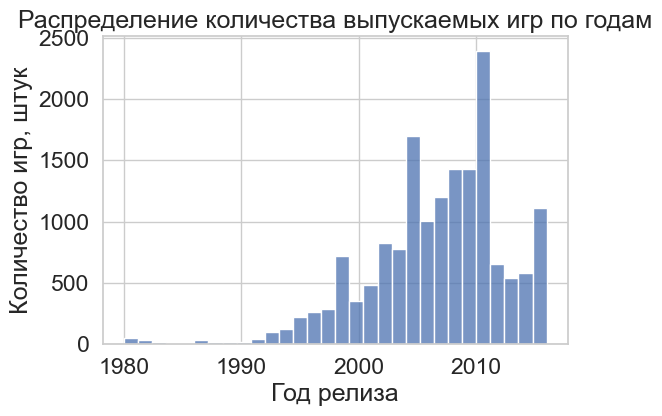

In [29]:
plt.figure(figsize=(6,4))
sns.set(style='whitegrid', font_scale=1.5)
sns.histplot(data=df_games['year'], bins=30)
plt.xlabel("Год релиза")
plt.ylabel("Количество игр, штук")
plt.title("Распределение количества выпускаемых игр по годам");

Мы видим, что наибольшее число игр (более 1000) появлялось в период с 2006 по 2010 годы. Более 100 игр в год появлялось с 1994 года. Однако по условиям задания мы должны предоставить прогноз на 2017 год, следовательно, необходимо использовать для прогнозирования лишь 3-4 предыдущих года, т.к. более старые данные устаревают. Т.о. в дальнейшем,будем исследовать данные за 2012-2016 годы. Поэтому мы можем точно отбросить данные в период с 1980 по  2011. 

### 3.2 Выберем лидирующие платформы по суммарным продажам.

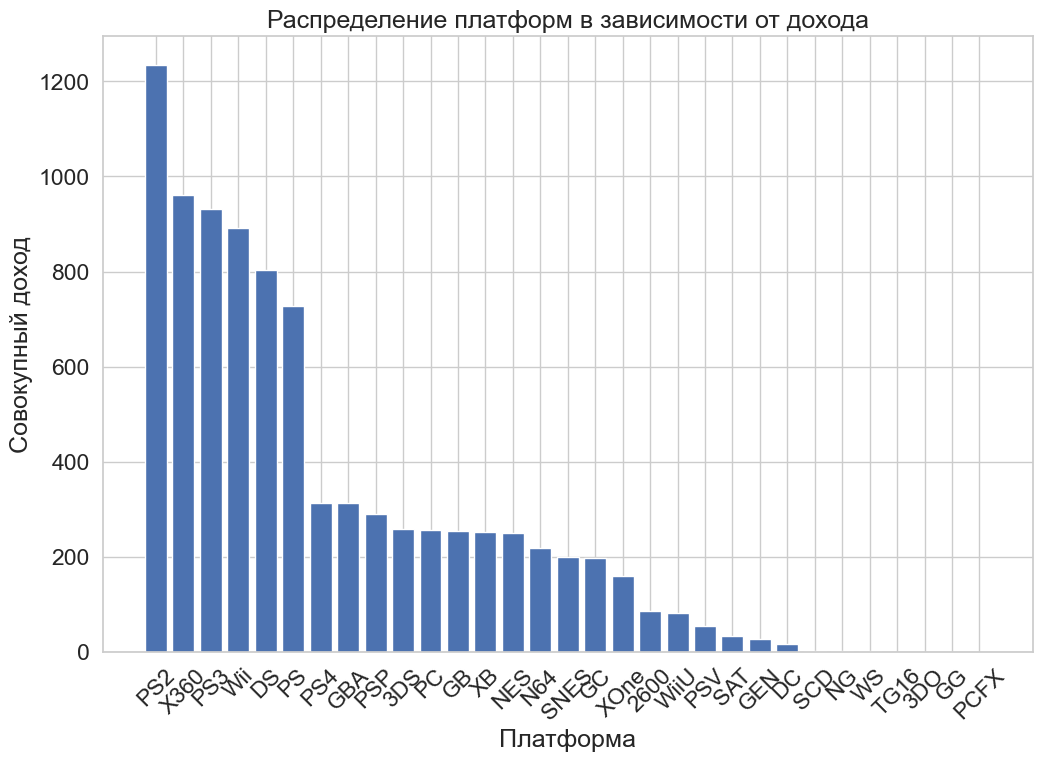

In [30]:
platform_income = df_games.groupby('platform')['income'].sum().reset_index()
platform_income = platform_income.sort_values(by='income', ascending=False)


# Постройте график
plt.figure(figsize=(12, 8))
plt.bar(platform_income['platform'], platform_income['income'])
plt.xticks(rotation=45)
plt.xlabel('Платформа')
plt.ylabel('Совокупный доход')
plt.title('Распределение платформ в зависимости от дохода')
plt.show()

Чтобы определить среднюю (на самом деле медианную) продолжительность жизни игровой платформы, необходимо подсчитать ее первое (min) и последнее (max) значение в столбце year (год)

In [31]:
temp = df_games.copy() # скопируем наш ДФ, чтобы не вносить изменения в исходный
time_life = temp.pivot_table(index='platform', values='year', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 
# в срок жизни платформы, должны входить границы диапазона, поэтому +1
time_life['life'].median()

7.0

In [32]:
time_life.sort_values(by='life', ascending=False)# покажем еще и всю таблицу по сроку жизни платформ

,platform,min,max,life
,,year,year,
13,PC,1985,2016,32
4,DS,1985,2013,29
5,GB,1988,2001,14
28,X360,2005,2016,12
19,PSP,2004,2015,12
16,PS2,2000,2011,12
11,NES,1983,1994,12
3,DC,1998,2008,11
26,Wii,2006,2016,11


### Отбросим данные за период ранее 2011 года и построим график распределения по годам.

In [33]:
df_new_games = df_games[df_games['year'] > 2011]

In [34]:
df_new_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year,income
16,Grand Theft Auto V,PS3,2013-01-01,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,2013,21.05
23,Grand Theft Auto V,X360,2013-01-01,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,2013,16.27
31,Call of Duty: Black Ops 3,PS4,2015-01-01,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,2015,14.63
33,Pokemon X/Pokemon Y,3DS,2013-01-01,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,undefined,2013,14.60
34,Call of Duty: Black Ops II,PS3,2012-01-01,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,2012,13.79


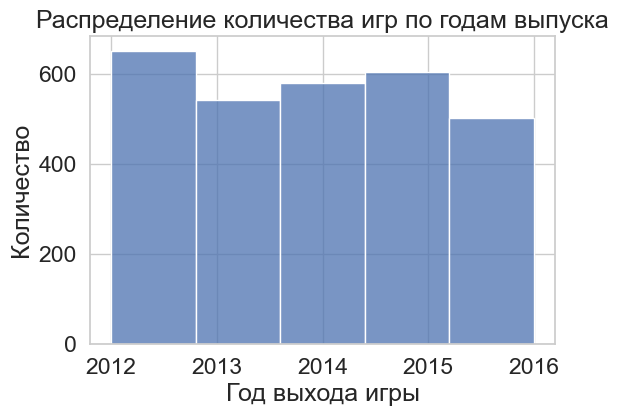

In [35]:
plt.figure(figsize=(6,4))
sns.set(style='whitegrid', font_scale=1.5)
sns.histplot(data=df_new_games['year'], bins=5)
plt.xlabel("Год выхода игры")
plt.ylabel("Количество")
plt.title("Распределение количества игр по годам выпуска");

Визуально, мы видим, что пиковый период для выпуска большого количества игр приходится на 2012 год, однако приблизительно все 4 года на уровне 450-610 игр.

### 3.4 Обратим внимание на платформы, на которых выходили игры. Проверим, как менялись продажи по платформам. Отберем платформы с наибольшими суммарными продажами и построим распределение по годам.

Сгруппируем наш ДФ по платформам и суммируем выручку.

In [36]:
platform_leader = df_new_games.groupby('platform')['income'].sum()

In [37]:
platform_leader.sort_values(ascending=False)

platform
PS4     314.14
PS3     288.78
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
PSP      11.19
Name: income, dtype: float64

Построим график распределения данных "ящик с усами" для всех представленных платформ, чтобы посмотреть, какие можно отобрать как лидирующие.

In [38]:
platform_leader_best = ['PS4','PS3','X360','3DS','XOne','WiiU','PC','PSV','Wii', 'DS', 'PSP']

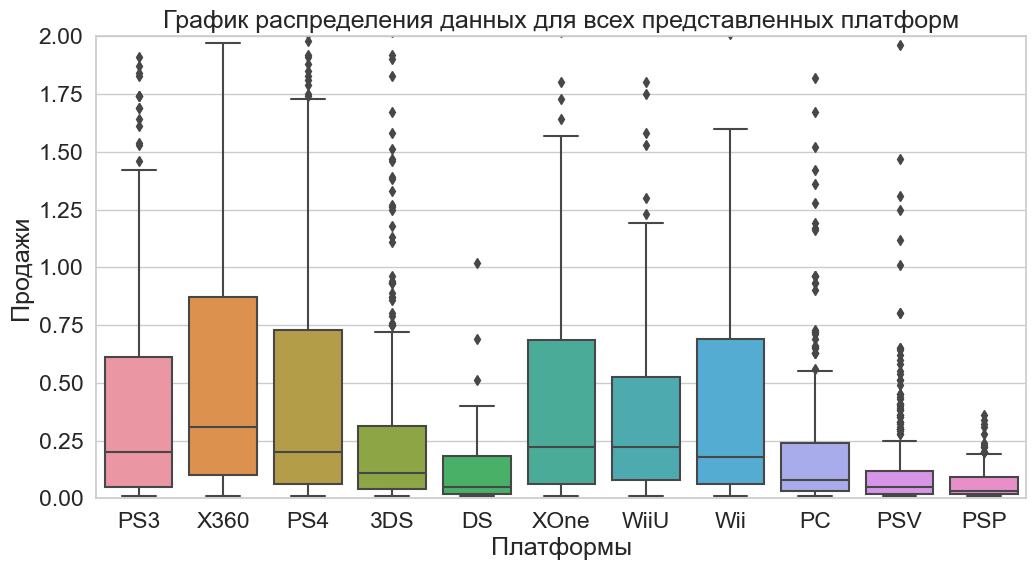

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = df_new_games.query('platform in @platform_leader_best'), y = 'income', x='platform').set(
    title = 'График распределения данных для всех представленных платформ', xlabel = 'Платформы', ylabel = 'Продажи')
plt.ylim(0, 2);

Проанализировав мадианные значения продаж, наибольший доход (более 80 млн копий) у 6 платформ: 'PS4','PS3','X360','XOne','WiiU', 'Wii'. Отдельно отметим платформу 3DS, которая по рейтингу и группировке показывала одну из лидирующих позиций (4 место), однако на графике мы видим, что большое количество данных лежат вне межквартильного размаха. Поэтому в вместо нее добавляем платформу Wii. 

Построим график распределения суммарного дохода по годам для каждой лидирующей платформы. 

In [40]:
platform_leader_PS4 = df_new_games[df_new_games['platform'] == 'PS4'].groupby('year', as_index=False)['income'].sum()

In [41]:
platform_leader_PS4

,year,income
0,2013,25.99
1,2014,100.00
2,2015,118.90
3,2016,69.25


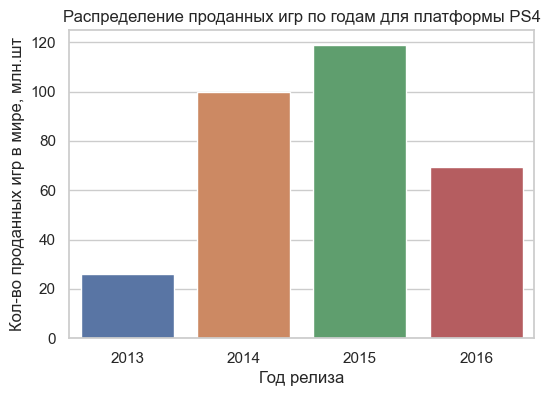

In [42]:
plt.figure(figsize=(6,4))
sns.set(style='whitegrid', font_scale=1.0)
sns.barplot(data=platform_leader_PS4, x='year', y='income')
plt.xlabel("Год релиза")
plt.ylabel("Кол-во проданных игр в мире, млн.шт")
plt.title("Распределение проданных игр по годам для платформы PS4");

### В период с 2013 по 2015 годы показан существенный рост продаж, однако в 2016 отмечается снижение почти в 2 раза по сравнению с предыдущим 2015 годом. Необходимо учитывать при прогнозе, что платформе всего 4 года (за 2012 год данных не предоставлено).

In [43]:
platform_leader_PS3 = df_new_games[df_new_games['platform'] == 'PS3'].groupby('year', as_index=False)['income'].sum()

In [44]:
platform_leader_PS3

,year,income
0,2012,107.35
1,2013,113.25
2,2014,47.76
3,2015,16.82
4,2016,3.60


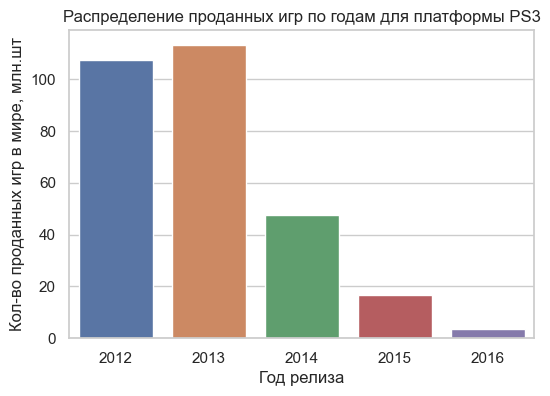

In [45]:
plt.figure(figsize=(6,4))
sns.set(style='whitegrid', font_scale=1.0)
sns.barplot(data=platform_leader_PS3, x='year', y='income')
plt.xlabel("Год релиза")
plt.ylabel("Кол-во проданных игр в мире, млн.шт")
plt.title("Распределение проданных игр по годам для платформы PS3");

### Рост активный отмечен в 2012-2013 года, последние 3 года существенное снижение продаж, особенно в 2016 году (почти в 40 раз по сравнению с лидирующим 2013 годом).

In [46]:
platform_leader_X360 = df_new_games[df_new_games['platform'] == 'X360'].groupby('year', as_index=False)['income'].sum()

In [47]:
platform_leader_X360

,year,income
0,2012,99.74
1,2013,88.58
2,2014,34.74
3,2015,11.96
4,2016,1.52


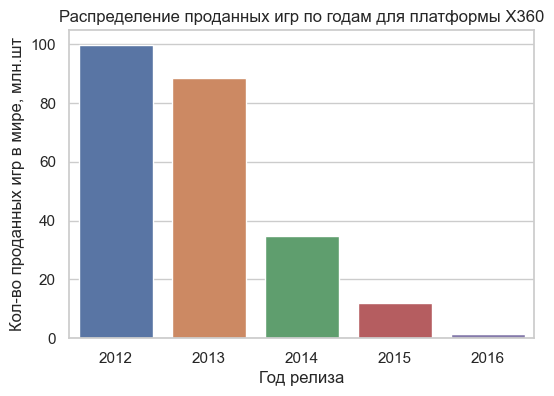

In [48]:
plt.figure(figsize=(6,4))
sns.set(style='whitegrid', font_scale=1.0)
sns.barplot(data=platform_leader_X360, x='year', y='income')
plt.xlabel("Год релиза")
plt.ylabel("Кол-во проданных игр в мире, млн.шт")
plt.title("Распределение проданных игр по годам для платформы X360");

### Отмечается тенденция с снижению продаж, особенно в 2016 году (почти в 50 раз по сравнению с лидером - 2012 годом). Роста за 5 лет не отмечено, значит тенденция  к снижению устойчивая. 

In [49]:
platform_leader_XOne = df_new_games[df_new_games['platform'] == 'XOne'].groupby('year', as_index=False)['income'].sum()

In [50]:
platform_leader_XOne

,year,income
0,2013,18.96
1,2014,54.07
2,2015,60.14
3,2016,26.15


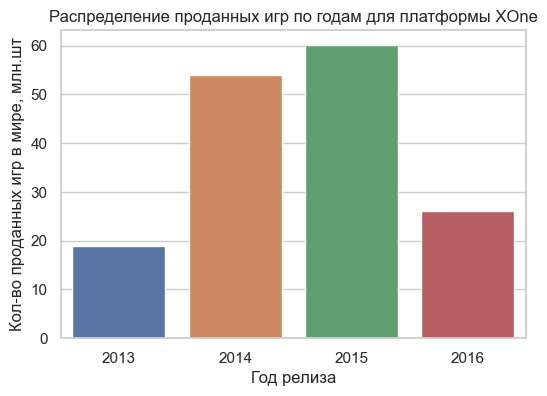

In [51]:
plt.figure(figsize=(6,4))
sns.set(style='whitegrid', font_scale=1.0)
sns.barplot(data=platform_leader_XOne, x='year', y='income')
plt.xlabel("Год релиза")
plt.ylabel("Кол-во проданных игр в мире, млн.шт")
plt.title("Распределение проданных игр по годам для платформы XOne");

### Отмечался подъем с 2013 по 2015 годы, в 2016 снизился (почти в 2 раза), но все еще выше уровня 2013 года. Платформа молодая, т.к. данных за 2012 год не представлено.

In [52]:
platform_leader_WiiU = df_new_games[df_new_games['platform'] == 'WiiU'].groupby('year', as_index=False)['income'].sum()

In [53]:
platform_leader_WiiU

,year,income
0,2012,17.56
1,2013,21.65
2,2014,22.03
3,2015,16.35
4,2016,4.60


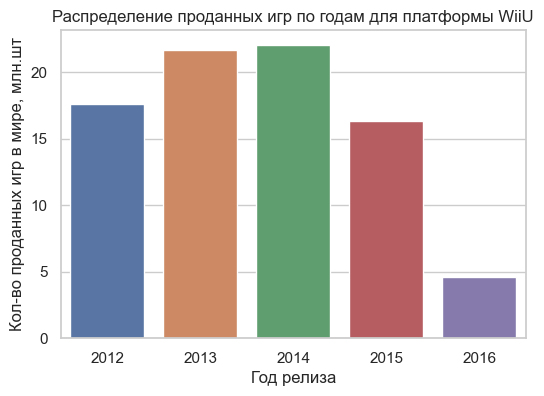

In [54]:
plt.figure(figsize=(6,4))
sns.set(style='whitegrid', font_scale=1.0)
sns.barplot(data=platform_leader_WiiU, x='year', y='income')
plt.xlabel("Год релиза")
plt.ylabel("Кол-во проданных игр в мире, млн.шт")
plt.title("Распределение проданных игр по годам для платформы WiiU");

### После роста в 2012-2014 годах тенденциия к снижению, особенно в 2016 (в 4 раза по сравнению с предыдущим). 

In [55]:
platform_leader_Wii = df_new_games[df_new_games['platform'] == 'Wii'].groupby('year', as_index=False)['income'].sum()

In [56]:
platform_leader_Wii

,year,income
0,2012,21.71
1,2013,8.59
2,2014,3.75
3,2015,1.14
4,2016,0.18


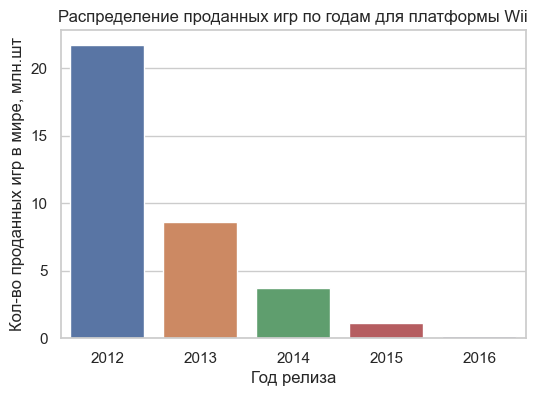

In [57]:
plt.figure(figsize=(6,4))
sns.set(style='whitegrid', font_scale=1.0)
sns.barplot(data=platform_leader_Wii, x='year', y='income')
plt.xlabel("Год релиза")
plt.ylabel("Кол-во проданных игр в мире, млн.шт")
plt.title("Распределение проданных игр по годам для платформы Wii");

### Платформа явно переживает не лучшие времена: после 2012 года идет резкое сокращений продаж, в 2016 году они на уровне 180 тысяч копий. Это не может быть лидирующей платформой. 

### На основе полученных данных , надо проверить платформу 3DS. Она показывала неплохие результаты. Надо посмотреть по годам. Т.к. по графикам мы видим, что почти все лидеры проседают по выручке после 2014-2015 годов. 

In [58]:
platform_leader_3DS = df_new_games[df_new_games['platform'] == '3DS'].groupby('year', as_index=False)['income'].sum()

In [59]:
platform_leader_3DS

,year,income
0,2012,51.36
1,2013,56.57
2,2014,43.76
3,2015,27.78
4,2016,15.14


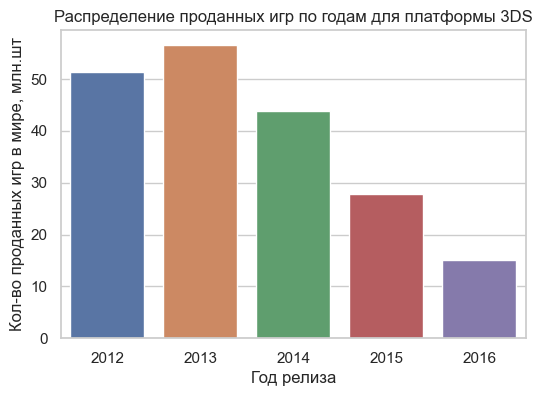

In [60]:
plt.figure(figsize=(6,4))
sns.set(style='whitegrid', font_scale=1.0)
sns.barplot(data=platform_leader_3DS, x='year', y='income')
plt.xlabel("Год релиза")
plt.ylabel("Кол-во проданных игр в мире, млн.шт")
plt.title("Распределение проданных игр по годам для платформы 3DS");

### Мы видим и здесь снижение с 2013 года, однако нет такого резкого падения как с платформами Wii и X360. У которых в 2016 году было продано всего 180 тысяч и  1,5 млн копий соответственно, при 15 млн у этой платформы.

### Таким образом, по результататм проведенного анализа для составления прогноза на 2017 год отобрано 6 платформ: PS4, PS3, X360, XOne, WiiU, 3DS. 

## 3.6 Проанализируем как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
### Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами для платформы PS4.

Мы помним, что в наших данных по рейтингам отзывов критиков и пользователей было достаточно много пропусков, которые мы не могли адекватно заполнить. Чтобы построить корреляцию между оценками пользователей и уровнем продаж, создадим новую таблицу, в которой оставим только данные по платформе PS4. 

In [61]:
platform_PS4 = df_new_games[df_new_games['platform'] == 'PS4']

In [62]:
platform_PS4

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year,income
31,Call of Duty: Black Ops 3,PS4,2015-01-01,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,2015,14.63
42,Grand Theft Auto V,PS4,2014-01-01,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,2014,12.62
77,FIFA 16,PS4,2015-01-01,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,2015,8.58
87,Star Wars Battlefront (2015),PS4,2015-01-01,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,undefined,2015,7.98
92,Call of Duty: Advanced Warfare,PS4,2014-01-01,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,2014,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16500,Root Letter,PS4,2016-01-01,Adventure,0.00,0.00,0.01,0.00,69.0,7.5,undefined,2016,0.01
16503,Shin Hayarigami 2,PS4,2016-01-01,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,undefined,2016,0.01
16526,Dungeons 2,PS4,2016-01-01,Role-Playing,0.01,0.00,0.00,0.00,61.0,7.9,T,2016,0.01
16530,Carmageddon: Max Damage,PS4,2016-01-01,Action,0.01,0.00,0.00,0.00,51.0,5.5,M,2016,0.01


In [63]:
platform_PS4[['critic_score','income']].corr()

,critic_score,income
critic_score,1.000000,0.406568
income,0.406568,1.000000


Мы видим, что для данной платформы существует небольшая прямая зависимость между рейтингом критиков и уровнем продаж. 0,4 это, конечно, не самая сильная корреляция, но это почти как 40% от прямой зависимости. Скорее всего, достаточно большое количество пользователей обращают внимание на экспертные рейтинги.

Коэффициент корреляции рассчитывается заново, без учета отзывов пользователей. Tbd в оценке критиков также были заменены на этапе подготовки данных ДФ, поэтому коэффициент корреляции и диаграмма рассеяния валидны

In [72]:
platform_PS4['user_score'].corr(platform_PS4['income'])

-0.031957110204556424

Рассчитанный коэффициент корреляции показывает, что зависимость между оценкай пользователей и уровнем продаж практически равна нулю.

Построим диаграмму рассеяния для зависимости уровня продаж и оценки критиков

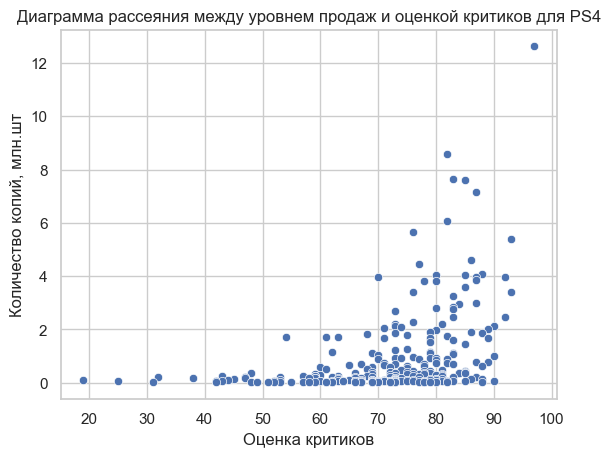

In [73]:
x_column = 'critic_score'
y_column = 'income'

# Создание диаграммы рассеяния для выбранных столбцов с использованием Seaborn
sns.scatterplot(data=platform_PS4, x=x_column, y=y_column)
plt.xlabel('Оценка критиков')
plt.ylabel('Количество копий, млн.шт')
plt.title(f'Диаграмма рассеяния между уровнем продаж и оценкой критиков для PS4')
plt.show()

Мы видим, что по мере увеличения баллов при оценке критиками игры, проявляется и увеличение общего количества продаж.

### Посчитаем коэффициенты корреляции между оценкой критиков и уровнем продаж для других платформ-лидеров. 

In [74]:
platforms_best = ['PS3','X360','3DS','XOne','WiiU']

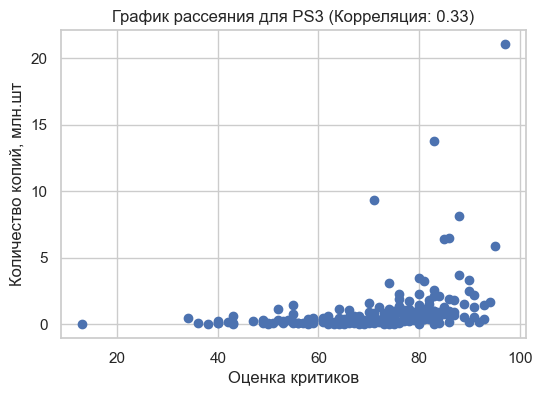

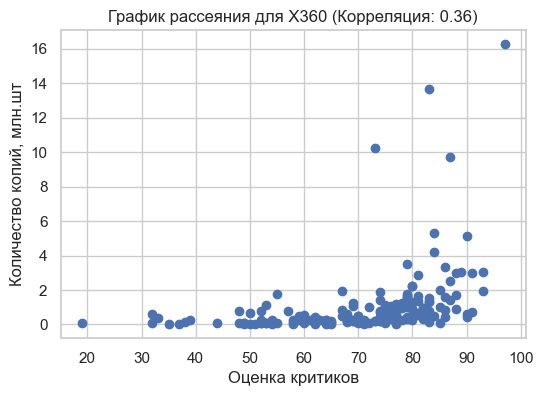

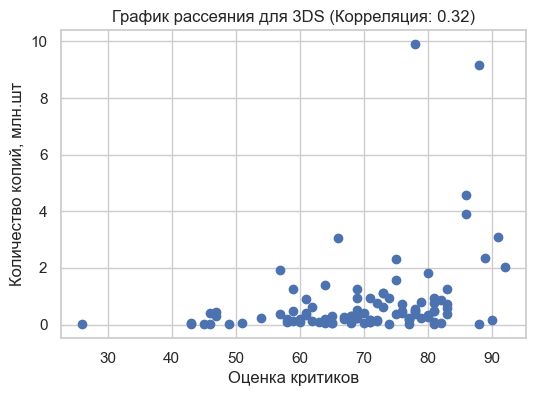

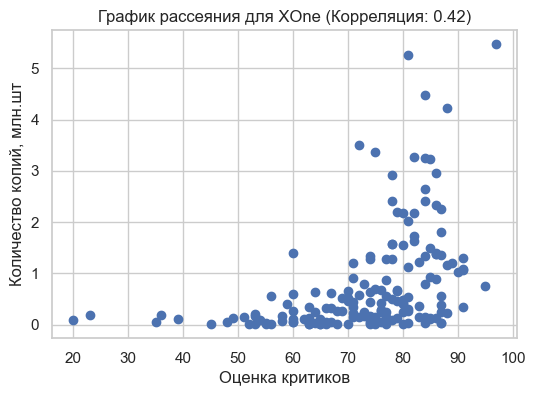

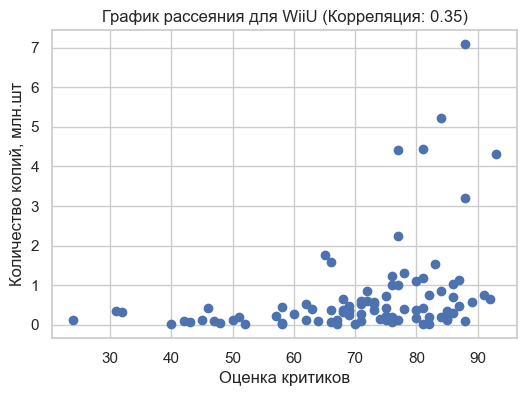

In [75]:
# Цикл для построения графиков рассеяния
for platform in platforms_best:
    platform_data = df_new_games.query('platform == @platform')[['critic_score', 'income']]
    correlation = platform_data.corr().iloc[0, 1]  # Получение коэффициента корреляции
    
    # Постройте график рассеяния
    plt.figure(figsize=(6, 4))
    plt.scatter(x=platform_data['critic_score'], y=platform_data['income'])
    plt.title(f'График рассеяния для {platform} (Корреляция: {correlation:.2f})')
    plt.xlabel('Оценка критиков')
    plt.ylabel('Количество копий, млн.шт')
    plt.show()


In [76]:
for platform in platforms_best:
    print(platform)
    df_new_games.query('platform == @platform')[['critic_score', 'income']].corr()
    print(df_new_games.query('platform == @platform')[['critic_score', 'income']].corr())
    print()
    

PS3
              critic_score    income
critic_score      1.000000  0.334152
income            0.334152  1.000000

X360
              critic_score    income
critic_score      1.000000  0.360573
income            0.360573  1.000000

3DS
              critic_score    income
critic_score      1.000000  0.320803
income            0.320803  1.000000

XOne
              critic_score    income
critic_score      1.000000  0.416998
income            0.416998  1.000000

WiiU
              critic_score   income
critic_score       1.00000  0.34838
income             0.34838  1.00000



Мы подсчитали коэффициенты корреляции для наших лидирующих платформ и можем сказать, что определенно, есть невысокая зависимость выручки от оценки критиками игр, но она не играет решабщую роль в выручке, т.к. варьирует от 0,32 до 0,41 по платформам.

### Посмотрим на общее распределение игр по жанрам. 

Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [77]:
df_new_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year,income
16,Grand Theft Auto V,PS3,2013-01-01,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,2013,21.05
23,Grand Theft Auto V,X360,2013-01-01,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,2013,16.27
31,Call of Duty: Black Ops 3,PS4,2015-01-01,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,2015,14.63
33,Pokemon X/Pokemon Y,3DS,2013-01-01,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,undefined,2013,14.60
34,Call of Duty: Black Ops II,PS3,2012-01-01,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,2012,13.79


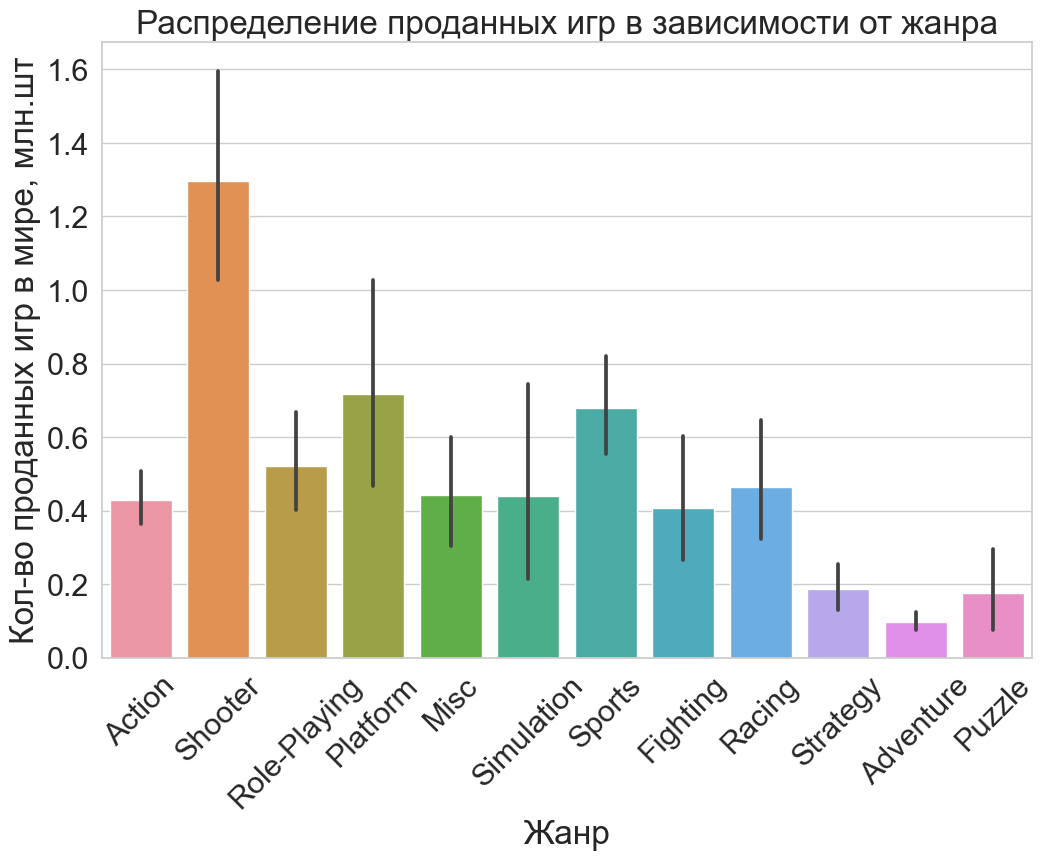

In [78]:
plt.figure(figsize=(12,8))
sns.set(style='whitegrid', font_scale=2.0)
sns.barplot(data=df_new_games, x='genre', y='income')
plt.xticks(rotation=45)
plt.xlabel("Жанр")
plt.ylabel("Кол-во проданных игр в мире, млн.шт")
plt.title("Распределение проданных игр в зависимости от жанра");

По данным, представленным на графике, мы можем сказать, что лидирующую роль занимают Шутеры (Стрелялки), затем идет Platform (Платформеры или Бродилки), достаточно близко к Бродилкам идут Спортивные игры, затем Ролевые и замыкает ТОП-5 игр Гонки. Наименее прибыльными оказались Приключения, Пазлы и Стратегии.

## Минивывод
1. Мы показали, что наибольшее число игр (более 1000) появлялось в период с 2006 по 2010 годы. 
2. Для составления прогноза на 2017 год мы будем использовать данные с **2012 по 2016 годы**. Пиковый период для выпуска большого количества игр приходится на 2012 год, однако приблизительно все 4 года на уровне 450-610 игр.
3. Наибольший доход (более 80 млн копий) у 6 платформ: 'PS4','PS3','X360','XOne','WiiU', 'Wii'. Отдельно отметим платформу 3DS, которая по рейтингу и группировке показывала одну из лидирующих позиций (4 место), однако на графике мы видим, что большое количество данных лежат вне межквартильного размаха. Поэтому вместе с ней добавляем еще и платформу Wii.
4. Проанализировав данные для платформы Wii (в 2016 году было продано всего 180 тысяч копий игр), мы принимаем решение изменить ТОП-6 литдеров. Для составления прогноза на 2017 год отобрано 6 платформ: PS4, PS3, X360, XOne, WiiU, 3DS.
5. Для самой прибыльной платформы PS4 коэффициент корреляции между рейтингом критиков и уровнем продаж равен 0,4. Это, конечно, не самая сильная корреляция, но необходимо учитывать, что достаточно большое количество пользователей обращают внимание на экспертные рейтинги.
6. Мы видим, что по мере увеличения баллов при оценке критиками игры, проявляется и увеличение выручки от ее продажи.
7. Коэффициент корреляции между оценкой пользователей и ростом выручки практически равен нулю, поэтому можно уверенно сказать, что оценка пользователей не зависит на уровень продаж и, соответственно, выручки.
8. Коэффициенты корреляции для ТОП-6 платформ показали, что определенно, есть невысокая зависимость выручки от оценки критиками игр, но она не играет решающую роль в выручке, т.к. варьирует от 0,32 до 0,41 по платформам.
9. При оценке популярных жанров показано, что лидирующую роль занимают Шутеры (Стрелялки), затем идет Platform (Платформеры или Бродилки), достаточно близко к Бродилкам идут Спортивные игры, затем Ролевые и замыкает ТОП-5 игр Гонки. Наименее прибыльными оказались Приключения, Пазлы и Стратегии.

## Шаг 4. Портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
Самые популярные платформы (топ-5). Опишите различия в долях продаж.
Самые популярные жанры (топ-5). Поясните разницу.
Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### Определим самые популярные платформы для региона Северная Америка (NA).

In [79]:
df_NA = df_new_games.groupby(by='platform', as_index=False)['na_sales'].sum()

In [80]:
df_NA = df_NA.sort_values(by='na_sales',ascending=False).head()

Покажем ТОП-5 платформ в СА

In [81]:
df_NA

,platform,na_sales
9,X360,140.05
4,PS4,108.74
3,PS3,103.38
10,XOne,93.12
0,3DS,55.31


Подсчитаем сколько приходится на **другие платформы** их общего дохода по региону по формуле: общий доход региона - сумма доходов ТОП-5 платформ.

In [82]:
another_platforms_na = df_new_games['na_sales'].sum() - df_NA['na_sales'].sum()

In [83]:
another_platforms_na # доход от других жанров в регионе СА

90.37

In [84]:
new_row_platform1 = {'platform': 'Другие', 'na_sales': 90.37} # Добавим строку в ДФ, чтобы удобнее использовать при построении графиков
df_NA = df_NA.append(new_row_platform1, ignore_index=True) # добавим новую строку

Построим круговую диаграмму распределения по платформам для CA

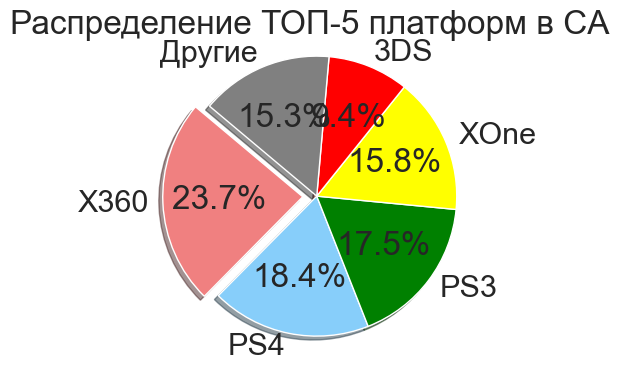

In [85]:
labels = df_NA['platform']
sizes = df_NA['na_sales']  # Размеры каждой категории
colors = ['lightcoral', 'lightskyblue', 'green','yellow', 'red', 'grey']  # Цвета для каждой категории
explode = (0.1, 0, 0, 0, 0, 0)  # Отступ для выделения категории

plt.figure(figsize=(6, 4))

# Постройте круговую диаграмму
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)

# Добавьте заголовок
plt.title('Распределение ТОП-5 платформ в CA')

# Отобразите круговую диаграмму
plt.axis('equal')  # Для круговой формы
plt.show()

В Северной Америке лидируюшая роль за платформой Х360. ТОП-5 платформ занимают 85% всего рынка продаж. Причем лидер Х360 занимает менее 1/4 от всего рынка, еще 3 компании примерно по 1/6 (+- 15%) и замыкающая - около 10% рынка. На совокупный доход от Других платформ приходится 15%, что составляет 1/6 часть от всех продаж. С точки зрения конкурентности такая ситуация хороша, т.к. платформы вынуждены бороться за покупателя и не являются монополистами.   

### Определим самые популярные платформы для региона Европа (EU).

In [86]:
df_EU = df_new_games.groupby(by='platform', as_index=False)['eu_sales'].sum()

In [87]:
df_EU = df_EU.sort_values('eu_sales',ascending=False).head()

Покажем ТОП-5 платформ в Европе

In [88]:
df_EU

,platform,eu_sales
4,PS4,141.09
3,PS3,106.85
9,X360,74.52
10,XOne,51.59
0,3DS,42.64


Подсчитаем сколько приходится на **другие платформы** из общего дохода по региону.

In [89]:
another_platforms_eu = df_new_games['eu_sales'].sum() - df_EU['eu_sales'].sum()

In [90]:
another_platforms_eu # доход от других жанров в регионе Европа

90.12000000000012

In [91]:
new_row_platform2 = {'platform': 'Другие', 'eu_sales': 90.12} # Добавим строку в ДФ, чтобы удобнее использовать при построении графиков
df_EU = df_EU.append(new_row_platform2, ignore_index=True) # добавим новую строку

Построим круговую диаграмму распределения по платформам для EU

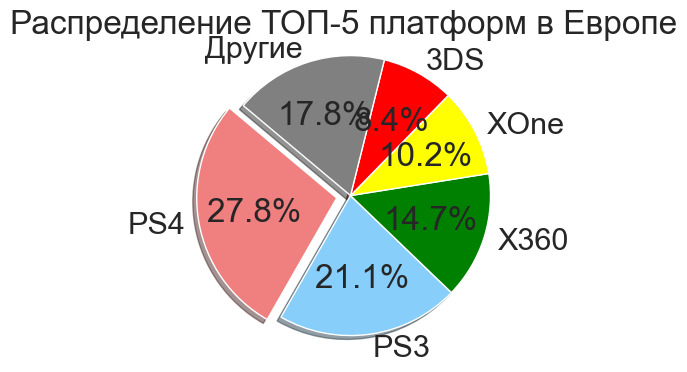

In [92]:
labels = df_EU['platform']
sizes = df_EU['eu_sales']  # Размеры каждой категории
colors = ['lightcoral', 'lightskyblue', 'green','yellow', 'red', 'grey']  # Цвета для каждой категории
explode = (0.1, 0, 0, 0, 0, 0)  # Отступ для выделения категории

plt.figure(figsize=(6, 4))
# Постройте круговую диаграмму
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)

# Добавьте заголовок
plt.title('Распределение ТОП-5 платформ в Европе')

# Отобразите круговую диаграмму
plt.axis('equal')  # Для круговой формы
plt.show()

 В Европе лидирующую позицию занимает платформа PS4. Лидер занимает чуть более 1/4 всего рынка, затем 1/5 идет вторая платформа, 1/6 - третья и две замыкающие - примерно по 10%. Все остальные компании занимают чуть более 1/6 части рынка. Опять же для конкурентности это не плохо, нет подавляющего лидера, все платформы должны конкурировать между собой. 
 Можно проанализировать лидера по жанрам игр, почему лидеры в Северной Америке и Европе различаются. Это влияние жанровых предпочтений пользователей или другие факторы.
 На совокупный доход от Других платформ приходится почти 18%, что составляет более 1/6 части от всех продаж.

### Определим платформы для региона Япония

In [93]:
df_JP = df_new_games.groupby(by='platform', as_index=False)['jp_sales'].sum()

In [94]:
df_JP = df_JP.sort_values(by='jp_sales', ascending=False).head()

Покажем ТОП-5 платформ в Японии

In [95]:
df_JP

,platform,jp_sales
0,3DS,87.79
3,PS3,35.29
6,PSV,21.04
4,PS4,15.96
8,WiiU,13.01


Подсчитаем сколько приходится на **другие платформы** их общего дохода по региону по формуле: общий доход региона - сумма доходов ТОП-5 платформ.

In [96]:
another_platforms_jp = df_new_games['jp_sales'].sum() - df_JP['jp_sales'].sum()

In [97]:
another_platforms_jp # доход от других жанров в регионе Япония

19.49000000000001

In [98]:
new_row_platform = {'platform': 'Другие', 'jp_sales': 19.49} # Добавим строку в ДФ, чтобы удобнее использовать при построении графиков
df_JP = df_JP.append(new_row_platform, ignore_index=True) # добавим новую строку

Построим круговую диаграмму распределения по платформам для Японии

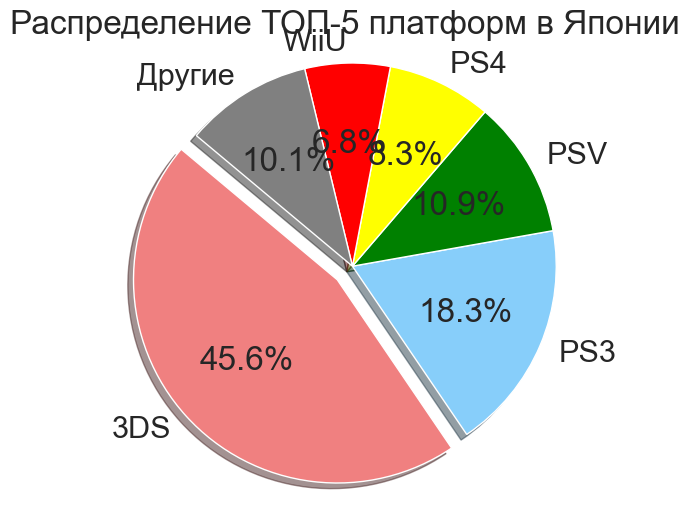

In [99]:
labels = df_JP['platform']
sizes = df_JP['jp_sales']  # Размеры каждой категории
colors = ['lightcoral', 'lightskyblue', 'green','yellow', 'red', 'grey']  # Цвета для каждой категории
explode = (0.1, 0, 0, 0, 0, 0)  # Отступ для выделения категории
plt.figure(figsize=(6, 6))
# Постройте круговую диаграмму
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)

# Добавьте заголовок
plt.title('Распределение ТОП-5 платформ в Японии')

# Отобразите круговую диаграмму
plt.axis('equal')  # Для круговой формы
plt.show()

В Японии есть явный лидер - платформа 3DS, занимающий почти половину всего рынка игр. Кроме того, в ТОП-5 попала платформа, которую мы не видели ни в СА, ни в Европе. Она так же не фигурировала среди лидеров в общем рейтинге - PSV. Можно проанализировать на каких жанрах специализируется эта платформа и предположить жанровые предпочтения именно для Японии. На совокупный доход от Других платформ приходится 10%, что составляет 1/10 часть от всех продаж.

## Определим популярные жанры в регионах (ТОП-5)

### Регион Япония

In [100]:
df_JP_genre = df_new_games.groupby('genre',as_index=False)['jp_sales'].sum()

In [101]:
df_JP_genre = df_JP_genre.sort_values(by='jp_sales', ascending=False).head()

Покажем ТОП-5 жанров в Японии

In [102]:
df_JP_genre

,genre,jp_sales
7,Role-Playing,65.44
0,Action,52.80
3,Misc,12.86
9,Simulation,10.41
2,Fighting,9.44


Подсчитаем сколько приходится на другие жанры их общего дохода по региону по формуле: общий доход региона - сумма доходов ТОП-5 по жанрам.

In [103]:
another_genre_jp = df_new_games['jp_sales'].sum() - df_JP_genre['jp_sales'].sum()

In [104]:
another_genre_jp # доход от других жанров в регионе Япония

41.629999999999995

In [105]:
new_row = {'genre': 'Другие', 'jp_sales': 41.63} # Добавим строку в ДФ, чтобы удобнее использовать при построении графиков
df_JP_genre = df_JP_genre.append(new_row, ignore_index=True) # добавим новую строку

Построим круговую диаграмму распределения по жанрам для Японии

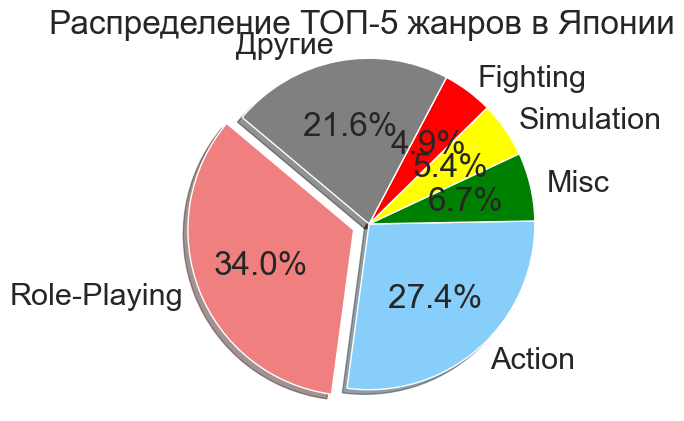

In [106]:
labels = df_JP_genre['genre']
sizes = df_JP_genre['jp_sales']  # Размеры каждой категории
colors = ['lightcoral', 'lightskyblue', 'green','yellow', 'red', 'grey']  # Цвета для каждой категории
explode = (0.1, 0, 0, 0, 0, 0)  # Отступ для выделения категории

# Постройте круговую диаграмму
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)

# Добавьте заголовок
plt.title('Распределение ТОП-5 жанров в Японии')

# Отобразите круговую диаграмму
plt.axis('equal')  # Для круговой формы
plt.show()

Мы видим, что в Японии лидирующее место занимают Игры-Персонажа (более 1/3), затем Экшен (чуть менее 1/3), затем Музыкальные, Симуляции и Файтинг(драки, борьба): всего по 5-6%. 1/5 часть отводится для всех остальных жанров в сумме. Доля Других жанров достигает более 20%.

### Регион Северная Америка

In [107]:
df_NA_genre = df_new_games.groupby('genre',as_index=False)['na_sales'].sum()

In [108]:
df_NA_genre = df_NA_genre.sort_values(by='na_sales', ascending=False).head()

Покажем ТОП-5 жанров в Северной Америке

In [109]:
df_NA_genre

,genre,na_sales
0,Action,177.84
8,Shooter,144.77
10,Sports,81.53
7,Role-Playing,64.00
3,Misc,38.19


Подсчитаем сколько приходится на другие жанры их общего дохода по региону по формуле: общий доход региона - сумма доходов ТОП-5 по жанрам.

In [110]:
another_genre_na = df_new_games['na_sales'].sum() - df_NA_genre['na_sales'].sum()

In [111]:
another_genre_na # доход от других жанров в регионе Северная Америка

84.64000000000004

In [112]:
new_row_1 = {'genre': 'Другие', 'na_sales': 84.64} # Добавим строку в ДФ, чтобы удобнее использовать при построении графиков
df_NA_genre = df_NA_genre.append(new_row_1, ignore_index=True) # добавим новую строку

Построим круговую диаграмму распределения по жанрам для Северной Америки

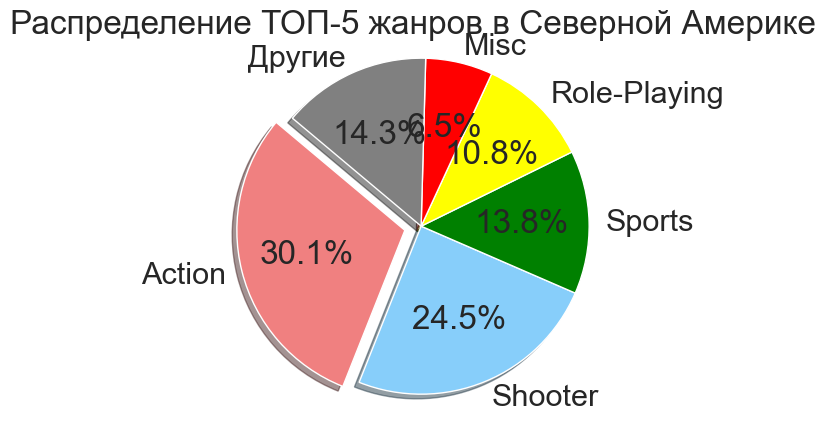

In [113]:
labels = df_NA_genre['genre']
sizes = df_NA_genre['na_sales']  # Размеры каждой категории
colors = ['lightcoral', 'lightskyblue', 'green','yellow', 'red', 'grey']  # Цвета для каждой категории
explode = (0.1, 0, 0, 0, 0, 0)  # Отступ для выделения категории

# Постройте круговую диаграмму
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)

# Добавьте заголовок
plt.title('Распределение ТОП-5 жанров в Северной Америке')

# Отобразите круговую диаграмму
plt.axis('equal')  # Для круговой формы
plt.show()

Мы видим, что в Северной Америке лидирующее место занимают Экшен игры (чуть менее 1/3), затем Стрелялки (почти 1/4), Спорт, Ролевые и Музыка. 1/6 часть отводится для всех остальных жанров в сумме.

### Регион Европа

In [114]:
df_EU_genre = df_new_games.groupby('genre',as_index=False)['eu_sales'].sum()

In [115]:
df_EU_genre = df_EU_genre.sort_values(by='eu_sales', ascending=False).head()

Покажем ТОП-5 жанров в Европе

In [116]:
df_EU_genre

,genre,eu_sales
0,Action,159.34
8,Shooter,113.47
10,Sports,69.08
7,Role-Playing,48.53
6,Racing,27.29


Подсчитаем сколько приходится на другие жанры их общего дохода по региону по формуле: общий доход региона - сумма доходов ТОП-5 по жанрам.

In [117]:
another_genre_eu = df_new_games['eu_sales'].sum() - df_EU_genre['eu_sales'].sum()

In [118]:
another_genre_eu # доход от других жанров в регионе Европа

89.10000000000008

In [119]:
new_row_2 = {'genre': 'Другие', 'eu_sales': 89.1} # Добавим строку в ДФ, чтобы удобнее использовать при построении графиков
df_EU_genre = df_EU_genre.append(new_row_2, ignore_index=True) # добавим новую строку

Построим круговую диаграмму распределения по жанрам для Европы

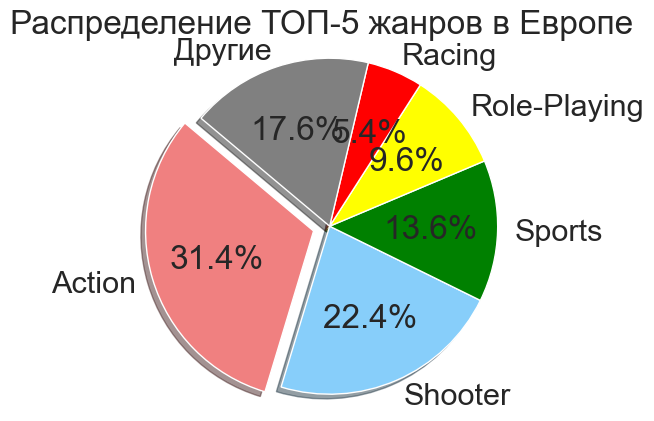

In [120]:
labels = df_EU_genre['genre']
sizes = df_EU_genre['eu_sales']  # Размеры каждой категории
colors = ['lightcoral', 'lightskyblue', 'green','yellow', 'red', 'grey']  # Цвета для каждой категории
explode = (0.1, 0, 0, 0, 0, 0)  # Отступ для выделения категории

# Постройте круговую диаграмму
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)

# Добавьте заголовок
plt.title('Распределение ТОП-5 жанров в Европе')

# Отобразите круговую диаграмму
plt.axis('equal')  # Для круговой формы
plt.show()

Мы видим, что в Европе, как и в Северной Америке лидирующее место занимают Экшен игры (чуть менее 1/3), затем Стрелялки (почти 1/4), Спорт, Ролевые и Гонки. Более 17% (>1/6 часть) отводится для всех остальных жанров в сумме.
Отличия в ТОП-5 между Европой и Северной Америкой лишь в последнем жанре (Гонки в Европе и Музыка в СА). В остальном, ТОП-5 для СА и Европы почти не различаются.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе

In [121]:
df_new_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year,income
16,Grand Theft Auto V,PS3,2013-01-01,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,2013,21.05
23,Grand Theft Auto V,X360,2013-01-01,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,2013,16.27
31,Call of Duty: Black Ops 3,PS4,2015-01-01,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,2015,14.63
33,Pokemon X/Pokemon Y,3DS,2013-01-01,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,undefined,2013,14.60
34,Call of Duty: Black Ops II,PS3,2012-01-01,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,2012,13.79


### Определим какие значения есть в рейтинге ESRB

In [122]:
df_new_games['rating'].unique()

array(['M', 'undefined', 'E', 'E10+', 'T'], dtype=object)

#### Определим зависимость продаж от рейтинга для Северной Америки

Способ №1

In [123]:
ESRB_NA = df_new_games.groupby('rating', as_index=False)['na_sales'].sum()

In [124]:
ESRB_NA

,rating,na_sales
0,E,114.37
1,E10+,75.70
2,M,231.57
3,T,66.02
4,undefined,103.31


Построим график зависимости продаж от рейтинга

In [125]:
ESRB_NA

,rating,na_sales
0,E,114.37
1,E10+,75.70
2,M,231.57
3,T,66.02
4,undefined,103.31


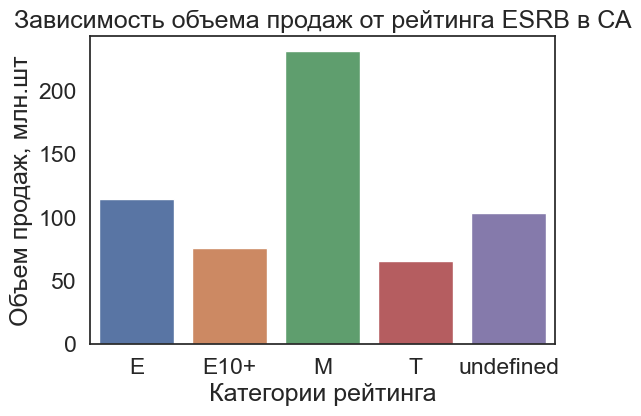

In [126]:
plt.figure(figsize=(6,4))
sns.set(style='white', font_scale=1.5)
sns.barplot(data=ESRB_NA, x='rating', y='na_sales')
plt.xlabel("Категории рейтинга")
plt.ylabel("Объем продаж, млн.шт")
plt.title("Зависимость объема продаж от рейтинга ESRB в СА");

Способ №2

In [127]:
esrball = df_new_games.groupby("rating", as_index=False).agg({"na_sales":"sum",
                                                             "eu_sales":"sum",
                                                             "jp_sales":"sum"})
# создадим общий ДФ для всех регионов

In [128]:
esrball

,rating,na_sales,eu_sales,jp_sales
0,E,114.37,113.02,28.33
1,E10+,75.70,55.37,8.19
2,M,231.57,193.96,21.20
3,T,66.02,52.96,26.02
4,undefined,103.31,91.50,108.84


In [129]:
esrball_melt = esrball.melt("rating")

In [130]:
esrball_melt['variable'] = esrball_melt['variable'].map({"na_sales":"Северная Америка",
                                                        "eu_sales":"Европа",
                                                        "jp_sales":"Япония"})

In [131]:
esrball_melt

,rating,variable,value
0,E,Северная Америка,114.37
1,E10+,Северная Америка,75.70
2,M,Северная Америка,231.57
3,T,Северная Америка,66.02
4,undefined,Северная Америка,103.31
5,E,Европа,113.02
6,E10+,Европа,55.37
7,M,Европа,193.96
8,T,Европа,52.96
9,undefined,Европа,91.50


Построим общий график зависимости объема продаж от рейтинга по 3 регионам

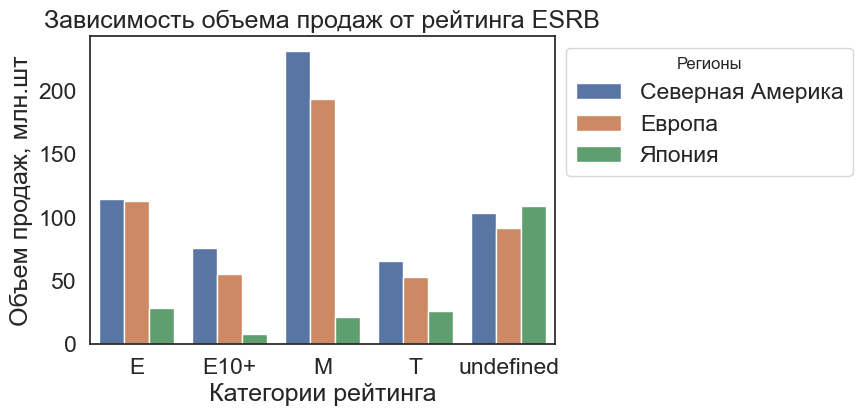

In [132]:
plt.figure(figsize=(6,4))
sns.set(style='white', font_scale=1.5)
sns.barplot(data=esrball_melt, x='rating', y='value', hue='variable')
legend = plt.legend(title="Регионы", title_fontsize="12")
legend.set_bbox_to_anchor((1, 1))  # Устанавливаем координаты положения легенды

plt.xlabel("Категории рейтинга")
plt.ylabel("Объем продаж, млн.шт")
plt.title("Зависимость объема продаж от рейтинга ESRB");

**По графику мы можем сделать вывод о том, что существует зависимость объема продаж от рейтинга игры, в т.ч. по регионам. 
Однако учитывать этот вывод и применять его для прогнозирования объемов продаж мы можем только для региона СА, т.к. рейтинг ESRB был разработан и применяется для игр, которые подлежат распространению в СА. Т.о. для остальных регионов он не является обязательным, поэтому сравнения  кол-ва продаж в зависимости от данного рейтинга не совсем корректны.**

## Минивывод
1. В Северной Америке лидирующая роль за платформой Х360. ТОП-5 платформ занимают 85% всего рынка продаж. Причем лидер Х360 занимает менее 1/4 от всего рынка, еще 3 компании примерно по 1/6 (+- 15%) и замыкающая - около 10% рынка. С точки зрения конкурентности такая ситуация хороша, т.к. платформы вынуждены бороться за покупателя и не являются монополистами.
2. В Европе лидирующую позицию занимает платформа PS4. Лидер занимает чуть более 1/4 всего рынка, затем 1/5 идет вторая платформа, 1/6 - третья и две замыкающие - примерно по 10%. Все остальные компании занимают чуть более 1/6 части рынка. Опять же для конкурентности это не плохо, нет подавляющего лидера, все платформы должны конкурировать между собой. Можно проанализировать лидера по жанрам игр, почему лидеры в Северной Америке и Европе различаются. Это влияние жанровых предпочтений пользователей или другие факторы.
3. В Японии есть явный лидер - платформа 3DS, занимающий почти половину всего рынка игр. Кроме того, в ТОП-5 попала платформа, которую мы не видели ни в СА, ни в Европе. Она так же не фигурировала среди лидеров в общем рейтинге - PSV. Можно проанализировать на каких жанрах специализируется эта платформа и предположить жанровые предпочтения именно для Японии.
4. При оценке жанровых предпочтений пользователей можно сказать, что в Японии лидирующее место занимают Игры-Персонажа (более 1/3), затем Экшен (чуть менее 1/3), затем Музыкальные, Симуляции и Файтинг(драки, борьба): всего по 5-6%. 1/5 часть отводится для всех остальных жанров в сумме.
5. В Северной Америке лидирующее место занимают Экшен игры (чуть менее 1/3), затем Стрелялки (почти 1/4), Спорт, Ролевые и Музыка. 1/6 часть отводится для всех остальных жанров в сумме.
6. В Европе, как и в Северной Америке лидирующее место занимают Экшен игры (чуть менее 1/3), затем Стрелялки (почти 1/4), Спорт, Ролевые и Гонки. 1/6 часть отводится для всех остальных жанров в сумме. Отличия в ТОП-5 между Европой и Северной Америкой лишь в последнем жанре (Гонки в Европе и Музыка в СА). В остальном, ТОП-5 для СА и Европы почти не различаются.
7. Существует зависимость объема продаж от рейтинга, присвоенного играм организацией ESRB, в т.ч. по регионам. Однако учитывать этот вывод и применять его для прогнозирования объемов продаж мы можем только для региона СА, т.к. рейтинг ESRB был разработан и применяется для игр, которые подлежат распространению в СА. Т.о. для остальных регионов он не является обязательным, поэтому сравнения  кол-ва продаж в зависимости от данного рейтинга не совсем корректны. 

## Шаг 5. Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Каким методом мы будем проверять данную гипотезу. У нас имеются данные для двух независимых друг от друга платформ, есть рейтинги пользователей, которые также были независимы для каждой из платформ. Поэтому будем считать, что это две независимые генеральные совокупности, в которых необходимо сравнить средние по определенному параметру (рейтинг пользователей). 

Формулируем нулевую гипотезу: H0 - средние пользовательские рейтинги для платформ Xbox One и PC равны.
Альтернативная гипотеза Н1 - средние пользовательские рейтинги для платформ Xbox One и PC не равны.


Подсчитаем среднюю для пользовательского рейтинга для платформы Xbox One. Мы помним, что в строке рейтинга пользователей было очень много пропусков Nan. Для подсчета среднего, придется удалить эти строки и подсчитать среднее только для имеющихся. Кроме того, удалим и строки, содержащие tbd.
Создадим новый ДФ для удобства.

In [133]:
df_new_games_user = df_new_games.dropna(subset=['user_score'])

По столбцу с оценкой пользователей мы так сделать не можем, т.к. в нем тип данных представлен в формате object, да еще и есть несколько значений tbd. 
Найдем эти значения и удалим их, а затем переведем тип данных в float

In [134]:
df_new_games_user = df_new_games_user[df_new_games_user['user_score'] != 'tbd']

In [135]:
df_new_games_user['user_score'] = df_new_games_user['user_score'].astype(float)

In [136]:
platf_XOne = df_new_games_user.query('platform == "XOne"')['user_score'].mean() # среднее для платформы XOne

In [137]:
platf_XOne

6.521428571428572

In [138]:
platf_PC = df_new_games_user.query('platform == "PC"')['user_score'].mean() # среднее для платформы PC

In [139]:
platf_PC

6.4286407766990274

In [140]:
# задаём уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем двустороннюю гипотезу.
results = st.ttest_ind(df_new_games_user.query('platform == "XOne"')['user_score'],
                       df_new_games_user.query('platform == "PC"')['user_score'], alternative='two-sided')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.5535080500643661
Нет оснований отвергнуть нулевую гипотезу


Соответственно, принимаем нулевую гипотезу, которая говорит, что **средние пользовательские рейтинги для платформ Xbox One и PC равны**.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.


У нас имеются независимые рейтинги пользователей по разным жанрам. Поэтому будем считать, что две генеральные совокупности, которые мы отберем для исследования по жанру Действие и Спорт являются независимыми, поэтому средние будем сравнивать как из двух независимых совокупностей. 

Формулируем нулевую гипотезу: H0 - средние пользовательские рейтинги для жанров Действие и Спорт равны.
Альтернативная гипотеза Н1 - средние пользовательские рейтинги для жанров Действие и Спорт не равны.


In [141]:
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем двустороннюю гипотезу.
results = st.ttest_ind(df_new_games_user.query('genre == "Action"')['user_score'],
                       df_new_games_user.query('genre == "Sports"')['user_score'], alternative='two-sided')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.8045233804629176e-26
Отвергаем нулевую гипотезу


In [142]:
genre_Ac = df_new_games_user.query('genre == "Action"')['user_score'].mean()

In [143]:
genre_Ac

6.825047801147227

In [144]:
genre_Sp = df_new_games_user.query('genre == "Sports"')['user_score'].mean()

In [145]:
genre_Sp

5.455670103092784

На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.

# вывод
1. Целью анализа данных было выявление закономерностей, определяющих успешность игры для прогнозирования потенциально популярного продукта.
2. Перед нами стояли следующие задачи:
- Подсчитать суммарные продажи во всех представленных регионах. 
- Выбрать несколько потенциально прибыльных платформ. 
- Определить, влияют ли на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
- Определить самые прибыльные жанры. 
- Составить портрет пользователя каждого региона.
3. Мы подготовили данные к анализу: заменили или удалили пропуски в рейтингах, подсчитали суммарный доход по каждой игре в 3-х регионах.
4. Определили актуальный период для составления прогнозного анализа на 2017 год - 2012-2016 годы.
5. Подсчитали совокупный доход компаний за актуальный период и посмотрели на графике распределение доходо по годам, в результате чего отобрали **ТОП-6 платформ-лидеров: PS4, PS3, X360, XOne, WiiU, 3DS**.
6. На примере самой прибыльной платформы PS4 рассчитали коэффициент корреляции между рейтингом критиков и уровнем продаж, который показал, что **достаточно большое количество пользователей обращают внимание на экспертные рейтинги**. Подобный эффект был показан на остальных платформах-лидерах.
7. В то же время, было показано, что коэффициент корреляции между оценкой пользователей и ростом выручки практически равен нулю, поэтому можно уверенно сказать, что **оценка пользователей не влияет на уровень продаж** и, соответственно, выручки.
8. При оценке популярных жанров показано, что **лидирующую роль занимают Шутеры (Стрелялки), затем идет Platform (Платформеры или Бродилки), достаточно близко к Бродилкам идут Спортивные игры, затем Ролевые и замыкает ТОП-5 игр Гонки**. Наименее прибыльными оказались Приключения, Пазлы и Стратегии.
9. Определили ТОП-5 платформ для **СА: X360, PS4, PS3, XOne, 3DS**. ТОП-5 платформ для Европы: **PS4, PS3, X360, XOne, 3DS**. ТОП-5 платформ для Японии: **3DS, PS3, PSV, PS4, WiiU**.
10. Определили ТОП-5 жанров для регионов. Для СА **Экшен, Шуттеры, Спорт, Ролевые, Музыка**. Для Европы: **Экшен, Шуттеры, Спорт, Ролевые, Гонки**. Для Японии: **Ролевые, Экшен, Музыка, Симуляторы, Драки**. 
11. Существует зависимость объема продаж от рейтинга игры по ESRB, в т.ч. по регионам. Однако учитывать этот вывод и применять его для прогнозирования объемов продаж мы можем только для региона СА, т.к. рейтинг ESRB был разработан и применяется для игр, которые подлежат распространению в СА. Т.о. для остальных регионов он не является обязательным, поэтому сравнения  кол-ва продаж в зависимости от данного рейтинга не совсем корректны.

# Рекомендации
1. для прогноза на 2017 год ориентироваться на новинки платформ ТОП-6 платформ-лидеров: PS4, PS3, X360, XOne, WiiU, 3DS.
2. Для всех регионов в жанрах можно продвигать Экшен, Шуттеры, Ролевые. Для СА и Европы дополнительно ориентироваться на Спортивные. Для Японии - Симуляторы.
3. Поскольку покупатели ориентируются на профессиональные оценки игр,  можно вкладываться в рекламу с использованием отзывов критиков (блогеры, проф сайты, проф.каналы и т.д.).